# Topic Models 1 - Gensim Topic Models and SciKit Learn

This notebook explores a number of topic modelling algorithms within Gensim and compares them using the coherence measure.

* Section 1 - Import libraries and dataset
* Section 2 - Set up Gensim Model
* Section 3 - Latent Semantic Indexing
* Section 4 - Latent Dirichlet Allocation


The full dataset is used here as topic models work better with more data.

# Secton 1: Import Libraries and Dataset

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import spacy
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel,Phrases
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf as GensimNmf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis.sklearn
from sklearn.manifold import TSNE
import ast
import warnings
warnings.filterwarnings("ignore")
import os
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#os.environ['MALLET_HOME'] = 'C:\\Users\\huang\\Downloads\\mallet\\mallet-2.0.8'

In [4]:
# Bring in files from Keywords Notebook
#df_accom = pd.read_csv("NOUNS_ACCOM.csv",index_col = 0)
#df_food = pd.read_csv("NOUNS_FOOD.csv",index_col = 0)
#df_attract = pd.read_csv("NOUNS_ATTRACT.csv",index_col = 0)

In [165]:
df = pd.read_csv("models1.csv")
df.shape

(7947, 12)

In [166]:
df["all_text"] = df["Title"] + " " + df["Review"]

In [146]:
# Run pre-processing on the full dataset
def process(text):
    
       
    # Strip whitespace and set to lowercase
    text = text.apply(lambda x: x.strip().lower())
    
    # Replace words, and remove the 'read more', 'read less' tags 
    text = text.apply(lambda x: x.replace('xmas','christmas'))
    text = text.apply(lambda x: x.replace('\nread less',""))
    text = text.apply(lambda x: x.replace('\nread more',""))
       
                  
    # Clean other issues with text
    text = text.replace({'\£':''}, regex = True) # remove pound sign
    text = text.replace(r'\/'," ", regex=True) # split words separated with slash
    text = text.replace({'\d+\-\d+':""}, regex = True) # remove digits
    text = text.replace({'\d+\w{2}':""}, regex = True) # remove number plus am, pm, th or nd
    text = text.replace({'\.{3,}':""}, regex = True) # remove multiple full stops not removed by punctuation
    
   # Expand contractions
    text = text.apply(lambda x: contractions.fix(x))

    # Tokenize text
    text = text.apply(lambda x: nltk.word_tokenize(x))
    
    # Remove punctuation
    punc = string.punctuation
    text = text.apply(lambda x: [word for word in x if word not in punc])
             
    # Remove numbers, except words that contain numbers.
    text = text.apply(lambda x: [n for n in x if not n.isnumeric()])

    # Remove non ascii characters
    text = text.apply(lambda x: [e for e in x if e.encode("ascii","ignore")])

    # Remove common/stopwords - extend and remove some words from the list as negation words might be important to retain
    stop = stopwords.words('english')
    stop_remove =["not","don't","didn't","wasn't","won't","isn't"]
    stop1 = [elem for elem in stop if elem not in stop_remove] 
    add_stop = ['etc','read','butlins', 'bognor','regis','b',' i '
                '..','arundel castle','premier','inn','u','castle',
                "year","hilton","time","day","shoreline","oyster","bay","church farm"]
    stop1.extend(add_stop)
    text = text.apply(lambda x: [w for w in x if w not in stop1])
    
    # Run spellchecker - (uncomment to run)
   # def spell_check(text):
        #spell = SpellChecker()
        #text2 = []
        #corrected = []
        #for word in text:
           # if spell.correction(word) != word:
               # new_word = spell.correction(word)
                #text2.append(new_word)
           # else:
                #text2.append(word)
       # return text2
    
    #text = text.apply(lambda x: spell_check(x))
             
    # Lemmatize to common root
    lemmatizer = WordNetLemmatizer()
    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in text]
    
    text = text.apply(lemmatize_text)
    
    # Convert list to string 
    text = text.apply(lambda x: ' '.join(x))
    
    # Remove trailing 'i'
    text = text.apply(lambda x: x.replace(' i ',""))
  
    return text

In [155]:
df2 = process(df["all_text"])

In [156]:
# Get parts of speech and nouns
df2 = pd.DataFrame(df2)
df2['pos'] = df2["all_text"].apply(lambda x:nltk.tag.pos_tag(x.split()))
df2['nouns'] = df2['pos'].apply(lambda x: [i[0] for i in x if i[1].startswith('N')])

In [167]:
# Concat to old dataframe
df = pd.concat([df2,df],axis = 1)
df = df[["Town","Category","all_text","Rating","nouns"]]

In [168]:
df_accom = df[df["Category"]=="Accommodation"]
df_food = df[df["Category"]=="Food"]
df_attract = df[df["Category"] =="Attractions"]

In [169]:
accom_nouns = df_accom["nouns"]
food_nouns = df_food["nouns"]
attract_nouns = df_attract["nouns"]

# Section 2: Set up Bigrams, Gensim Dictionaries and Bag of Words Corpus for Models

In [129]:
# Functions to extract bigrams
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts,min_count = 1,threshold = 1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

In [130]:
# Run function
accom_nouns_bigrams = make_bigrams(accom_nouns)
food_nouns_bigrams = make_bigrams(food_nouns)
attract_nouns_bigrams = make_bigrams(attract_nouns)

In [131]:
accom_nouns_bigrams

[['value',
  'heart_arundel',
  'room',
  'night',
  'hotel_street',
  'car_park.',
  'rooms_breakfast',
  'value_money',
  'recommend._read'],
 ['food,service',
  'we’ve',
  'eaten',
  'group_friends',
  'months_times',
  'years',
  'months.',
  'we’ve',
  'welcome_service',
  'class',
  'relaxed,',
  'helpful',
  'food',
  'i',
  'group',
  'anything',
  'courses',
  'fussy',
  'times!).',
  'selection_quality',
  'fish',
  'meat,',
  'presentation,',
  'quantities.',
  'prices',
  'value_money',
  'quality',
  'class',
  'service,',
  'ambience.',
  'criticism',
  'relation',
  'toilet',
  'quality',
  'elsewhere.'],
 ['swan',
  'drinks,',
  'time',
  'service',
  'prosecco',
  'bottles',
  'cold',
  'bar',
  'tables'],
 ['site',
  'nights',
  'bognor_regis.',
  'lidl',
  'bognor',
  'mile',
  'away.',
  'walk',
  'cinema',
  'swimming_pool',
  'calorie',
  'burn',
  'off.'],
 ['night,_room',
  'lots',
  'parking,',
  'downside',
  'fi',
  'phone_signal',
  'room.',
  'buffet_breakf

In [111]:
# Function to create dictionary and bow corpus for each category, filtering words that occur in more than 98% documents and less than 2 documents
def run_topic(df):
    dictionary = gensim.corpora.Dictionary(df)
    dictionary.filter_extremes(no_below = 0.95, no_above = 2)
    bow_corpus = [dictionary.doc2bow(doc) for doc in df]
    return dictionary,bow_corpus


In [112]:
# Create dictionaries and corpi for unigrams
accom_dict, accom_bow = run_topic(accom_nouns)
food_dict, food_bow = run_topic(food_nouns)
attract_dict, attract_bow = run_topic(attract_nouns)

In [113]:
# Create dictionaries and corpi for bigrams
accom_dict_big, accom_bow_big = run_topic(accom_nouns_bigrams)
food_dict_big, food_bow_big = run_topic(food_nouns_bigrams)
attract_dict_big, attract_bow_big = run_topic(attract_nouns_bigrams)

In [114]:
# Look at an example
print([[(accom_dict[id], freq) for id, freq in cp] for cp in accom_bow[0:1]])

[[('arundel', 1), ('breakfast', 1), ('car', 1), ('heart', 1), ('hotel', 1), ('money', 1), ('night', 1), ('park.', 1), ('read', 1), ('recommend.', 1), ('room', 1), ('rooms', 1), ('street', 1), ('value', 2)]]


# Section 3: Latent Semantic Indexing Model

In [115]:
# Function to run LSI Model
def lsi(corpus, num_topics,dictionary):
    lsi_model = LsiModel(corpus = corpus,num_topics = num_topics, id2word = dictionary, chunksize = 500)
    return lsi_model

In [116]:
# run function for each category
num_topics = 5

lsi_accom = lsi(accom_bow_big, num_topics, accom_dict_big)
lsi_food = lsi(food_bow_big, num_topics, food_dict_big)
lsi_attract = lsi(attract_bow_big, num_topics, attract_dict_big)

In [117]:
# Show topics as a list
lsi_accom_topics = lsi_accom.show_topics(formatted = False)
lsi_food_topics = lsi_food.show_topics(formatted = False)
lsi_attract_topics = lsi_attract.show_topics(formatted = False)

In [121]:
# Look at the accommodation category
lsi_accom_topics

[(0,
  [('i', 0.5114645166600461),
   ('room', 0.26548425196597203),
   ('read', 0.23516708742710918),
   ('hotel', 0.1798019294301994),
   ('time', 0.1711611156923928),
   ('staff', 0.16997090790760253),
   ('kids', 0.16758516316780303),
   ('food', 0.13669848564917358),
   ('day', 0.13080123110791161),
   ('people', 0.11767526538015265)]),
 (1,
  [('i', -0.6233445902541755),
   ('kids', 0.2099530880115448),
   ('child', 0.1772006777065904),
   ('tv', 0.1289652089065943),
   ('time', 0.1279264389596551),
   ('activities', 0.11289142362171514),
   ('queue', 0.1050126692830151),
   ('butlins', 0.10360420296425761),
   ('day', 0.09872807952121494),
   ('slides', 0.09280197891516154)]),
 (2,
  [('tv', -0.276597173431659),
   ('night', -0.19508983694817442),
   ('child', 0.178450951358937),
   ('morning', -0.17807322522942173),
   ('i', -0.17220006897996923),
   ('sunday', -0.14205783872961503),
   ('granddaughter', -0.1384508477453085),
   ('kids', 0.13535317997273394),
   ('butlins', 0.1

Topics seem a little fuzzy

In [119]:
# Look at the food category
lsi_food_topics

[(0,
  [('i', 0.8108039711112921),
   ('food', 0.3878072204582664),
   ('staff', 0.15135829365191283),
   ('service', 0.1032540813102753),
   ('restaurant', 0.10006516194824706),
   ('meal', 0.09709504193491789),
   ('time', 0.09372787179074898),
   ('place', 0.09302148754855985),
   ('table', 0.07838817966250086),
   ('menu', 0.06046101200903624)]),
 (1,
  [('food', 0.8045419478360907),
   ('i', -0.5125891409813507),
   ('staff', 0.11328866476195872),
   ('place', 0.08678400023358912),
   ('restaurant', 0.08495749073746393),
   ('service', 0.07243226716430395),
   ('time', 0.06385302397334507),
   ('meal', 0.05604073441694665),
   ('table', 0.05165891865034382),
   ('lunch', 0.039500337103006544)]),
 (2,
  [('staff', 0.5736838341181285),
   ('food', -0.4017185608801483),
   ('restaurant', 0.23598836895777583),
   ('meal', 0.21143352113510636),
   ('i', -0.2100751961490612),
   ('time', 0.20341932215985434),
   ('service', 0.1727462689777988),
   ('place', 0.17169648979286425),
   ('lu

Again topics are fuzzy, especially food and staff

In [120]:
# Look at the attractions category
lsi_attract_topics

[(0,
  [('i', 0.5325495470775078),
   ('read', 0.4299309697034642),
   ('day', 0.24826816322604145),
   ('castle', 0.22363780348568052),
   ('place', 0.16689490772765564),
   ('staff', 0.1604951055288294),
   ('gardens', 0.1308489603217208),
   ('time', 0.12325629794457144),
   ('visit', 0.10452636270479065),
   ('people', 0.1034219771401915)]),
 (1,
  [('i', 0.697424177411083),
   ('read', -0.46235349626067795),
   ('castle', -0.2379910094263219),
   ('dogs', 0.1077506623245881),
   ('visit', -0.09129400582017334),
   ('gardens', -0.09100490764745757),
   ('day', -0.08594286883663867),
   ('staff', -0.07925640799466177),
   ('dog', 0.07813947357531172),
   ('lots', -0.07000266337951185)]),
 (2,
  [('read', 0.5897104523346651),
   ('castle', -0.38297515932650905),
   ('day', -0.18268225865401488),
   ('staff', -0.14379296243493406),
   ('gardens', -0.1376560995664975),
   ('way', -0.13621224305669377),
   ('park', 0.11358193083087939),
   ('people', -0.09494362433848055),
   ('garden',

There is quite a lot of overlap in these topics which are not distinct, perhaps because the number of topics of 5 is too high for attractions

# Section 4: Latent Dirichlet Allocation Model

In [246]:
# Define model
def lda(corpus, dictionary, num_topics):
    lda_model = LdaModel(corpus = corpus, num_topics=num_topics, id2word=dictionary,random_state = 42)
    return lda_model

In [247]:
# Run models for each category
num_topics = 5
lda_accom = lda(accom_bow_big, accom_dict_big,num_topics)
lda_food = lda(food_bow_big, food_dict_big,num_topics)
lda_attract = lda(attract_bow_big, attract_dict_big,num_topics)

In [248]:
# Gather the topics for the 5 topic models for the categories to use in the evaluation process below
lda_accom_topics = lda_accom.show_topics(formatted = False)
lda_food_topics = lda_food.show_topics(formatted = False)
lda_attract_topics = lda_attract.show_topics(formatted = False)

In [249]:
lda_accom_topics

[(0,
  [('room', 0.0104443915),
   ('hotel', 0.009409205),
   ('staff', 0.009364302),
   ('experience', 0.007959773),
   ('night', 0.0077503473),
   ('place', 0.0069231275),
   ('area', 0.0069106393),
   ('weekend', 0.0059842286),
   ('breakfast', 0.005773436),
   ('stay', 0.0055081267)]),
 (1,
  [('room', 0.010374745),
   ('hotel', 0.008619734),
   ('night', 0.0082133645),
   ('food', 0.007541774),
   ('resort', 0.0051664864),
   ('accommodation', 0.004632325),
   ('pool', 0.004606167),
   ('reception', 0.004340854),
   ('way', 0.004281112),
   ('service', 0.003907936)]),
 (2,
  [('room', 0.018605638),
   ('stay', 0.007294956),
   ('breakfast', 0.0071853506),
   ('night', 0.0069331652),
   ('food', 0.0055242693),
   ('staff', 0.0050681084),
   ('thing', 0.004745615),
   ('family', 0.004567243),
   ('everything', 0.0042666956),
   ('restaurant', 0.0040850397)]),
 (3,
  [('room', 0.010968441),
   ('hotel', 0.007981361),
   ('floor', 0.0065369853),
   ('place', 0.006330715),
   ('family'

In [250]:
lda_food_topics

[(0,
  [('food', 0.020223273),
   ('staff', 0.011831588),
   ('service', 0.011011908),
   ('place', 0.008206474),
   ('meal', 0.007479575),
   ('restaurant', 0.006539718),
   ('order', 0.006052949),
   ('family', 0.0056659803),
   ('customer', 0.005020453),
   ('waitress', 0.0049940646)]),
 (1,
  [('food', 0.026648661),
   ('staff', 0.013344587),
   ('restaurant', 0.009046756),
   ('visit', 0.0067458726),
   ('place', 0.0065417346),
   ('service', 0.0063043693),
   ('lunch', 0.00510611),
   ('area', 0.0045940722),
   ('menu', 0.004478265),
   ('table', 0.004290198)]),
 (2,
  [('food', 0.013444066),
   ('staff', 0.011159782),
   ('chip', 0.008455939),
   ('meal', 0.0063628536),
   ('restaurant', 0.0051050144),
   ('place', 0.0050299345),
   ('night', 0.005025548),
   ('shame', 0.004491599),
   ('service', 0.004476766),
   ('visit', 0.0043862085)]),
 (3,
  [('place', 0.01445297),
   ('food', 0.011952038),
   ('meal', 0.010300642),
   ('service', 0.010286456),
   ('night', 0.005047513),
 

In [251]:
lda_attract_topics

[(0,
  [('beach', 0.024924358),
   ('car_park', 0.01734181),
   ('area', 0.012796116),
   ('play', 0.01055314),
   ('money', 0.008738046),
   ('month', 0.008368179),
   ('dog', 0.008356344),
   ('room', 0.008227691),
   ('experience', 0.008164647),
   ('lot', 0.008139655)]),
 (1,
  [('food', 0.019782066),
   ('room', 0.010441669),
   ('way', 0.009953608),
   ('meal', 0.009777968),
   ('sign', 0.008015318),
   ('adult', 0.0076953378),
   ('price', 0.007533177),
   ('hop', 0.0075279647),
   ('kid', 0.0075254356),
   ('plug_socket', 0.0075107496)]),
 (2,
  [('thing', 0.013111305),
   ('beach', 0.013011176),
   ('class', 0.012824246),
   ('area', 0.01224899),
   ('car_park', 0.011633643),
   ('membership', 0.010712219),
   ('week', 0.009166094),
   ('lot', 0.0077606267),
   ('price', 0.0075171087),
   ('employee', 0.0071016164)]),
 (3,
  [('visit', 0.0173209),
   ('area', 0.0120058535),
   ('staff', 0.011270486),
   ('place', 0.011234363),
   ('hour', 0.007853203),
   ('month', 0.007608015

In [253]:
# Function to get the average coherence and perplexity from the model

def average_metrics(lda_model,bow_corpus):
    tm = lda_model.top_topics(bow_corpus, topn = 10)
    average_tm = np.mean([item[1] for item in tm])
    perplexity = lda_model.log_perplexity(bow_corpus)
    print("Average Coherence:",average_tm)
    print("Average Perplexity:", perplexity)
                        

In [91]:
average_metrics(lda_accom,accom_bow)

Average Coherence: -15.017770374111242
Average Perplexity: -8.935973195754848


In [92]:
average_metrics(lda_food,food_bow)

Average Coherence: -18.5051920327844
Average Perplexity: -9.156138324292927


In [93]:
average_metrics(lda_attract,attract_bow)

Average Coherence: -18.982040003057456
Average Perplexity: -7.8759056084886545


Want the highest coherence and lowest perplexity. Need these values over different topic numbers to determine which is the optimum number of topics for each category

In [106]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz_accom = gensimvis.prepare(lda_accom,accom_bow_big, accom_dict_big)
lda_vis_food = gensimvis.prepare(lda_food, food_bow, food_dict_big)
lda_vis_attract = gensimvis.prepare(lda_attract, attract_bow, attract_dict_big)

In [108]:
lda_viz_accom

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.036100  0.038045       1        1  31.914187
3     -0.026012 -0.002328       2        1  22.979805
0      0.024606  0.020996       3        1  18.612951
2      0.023612 -0.064178       4        1  13.879909
1     -0.058305  0.007465       5        1  12.613148, topic_info=           Term        Freq       Total Category  logprob  loglift
4     breakfast   34.000000   34.000000  Default  30.0000  30.0000
111        food   38.000000   38.000000  Default  29.0000  29.0000
14         room  134.000000  134.000000  Default  28.0000  28.0000
268        stay   39.000000   39.000000  Default  27.0000  27.0000
59        night   59.000000   59.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
245     weekend    3.197706   33.398110   Topic5  -5.8711  -0.2756
156       place    3.347914   46.512300   Topic5  -5.8252  -0.5609
130        area    3.138613   37.169646   Topic5  -5.8898  -0.4013
263  restaurant    2.926799   26.400388   Topic5  -5.9596  -0.1290
360       floor    2.917918   37.013669   Topic5  -5.9627  -0.4700

[410 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2261      5  0.730771             -5
127       1  0.360089  accommodation
127       2  0.240059  accommodation
127       3  0.160040  accommodation
127       4  0.040010  accommodation
...     ...       ...            ...
1825      3  0.469736         winner
2188      4  0.735147         winter
2281      5  0.485592          woman
327       2  0.630254       woodland
68        4  0.735159             xu

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

In [110]:
lda_vis_food

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.016566 -0.046143       1        1  33.785272
0     -0.019052  0.001865       2        1  23.182889
1     -0.015514 -0.036675       3        1  19.669129
3     -0.031594  0.069934       4        1  14.934573
4      0.082726  0.011020       5        1   8.428137, topic_info=          Term        Freq       Total Category  logprob  loglift
29        food  347.000000  347.000000  Default  30.0000  30.0000
211      place  148.000000  148.000000  Default  29.0000  29.0000
7         meal  133.000000  133.000000  Default  28.0000  28.0000
60   breakfast   52.000000   52.000000  Default  27.0000  27.0000
100    service  146.000000  146.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
562      sauce    4.362350   35.209184   Topic5  -5.9776   0.3853
332     dinner    4.527939   43.448751   Topic5  -5.9404   0.2123
146      money    4.454917   39.954397   Topic5  -5.9566   0.2799
14        wife    4.426267   50.080363   Topic5  -5.9631   0.0475
211      place    4.566047  148.460092   Topic5  -5.9320  -1.0081

[415 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2840      2  0.731439          age_get
2868      4  0.729301             alan
79        1  0.346881             area
79        2  0.219083             area
79        3  0.328624             area
...     ...       ...              ...
76        3  0.184487             year
76        4  0.342618             year
76        5  0.052710             year
2760      4  0.729258  year_management
1600      5  0.484700    yogurt_coffee

[813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

In [111]:
lda_vis_attract

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.103473 -0.040879       1        1  29.667381
0     -0.055467 -0.080286       2        1  22.401546
4      0.022960  0.045997       3        1  20.811822
2     -0.064650  0.013793       4        1  14.639367
1     -0.006317  0.061376       5        1  12.479884, topic_info=         Term       Freq      Total Category  logprob  loglift
126     beach  11.000000  11.000000  Default  30.0000  30.0000
288  car_park   7.000000   7.000000  Default  29.0000  29.0000
32       food   8.000000   8.000000  Default  28.0000  28.0000
498     class   3.000000   3.000000  Default  27.0000  27.0000
64       room   9.000000   9.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
92      thing   0.735649   4.737260   Topic5  -5.3060   0.2186
165      area   0.798255  11.941750   Topic5  -5.2243  -0.6243
71      visit   0.783787  10.817758   Topic5  -5.2426  -0.5438
33     ground   0.714782   5.166569   Topic5  -5.3348   0.1031
143     staff   0.725745  10.187901   Topic5  -5.3195  -0.5607

[307 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
360       3  0.720255      admire
45        1  0.319552       adult
45        3  0.319552       adult
45        5  0.319552       adult
435       1  0.617706         ann
...     ...       ...         ...
233       1  0.617691  whatsoever
366       3  0.720227        wild
234       1  0.805321      winter
148       3  0.720233    workshop
235       1  0.617638         yes

[381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [263]:
# Function to collect topic coherence and respective weights

def results(dictionary, corpus, texts,start,stop,step):
    
    # Get coherence values
    cv = []
    tm_list = []
    for num_topics in range(start,stop,step):
        tm = LdaModel(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        tm_list.append(tm)
        cm = CoherenceModel(model = tm, texts = texts, dictionary = dictionary, coherence = 'c_v')
        cv.append(cm.get_coherence())
    
    # Graph results
    x = range(start, stop, step)
    fig, ax = plt.subplots()
    ax.set_facecolor("White")
    ax.plot(x,cv)
    ax.set_xlabel("Number of Topics")
    ax.set_ylabel("Coherence Score")
    ax.legend(("c_v"), loc = 'best')
    ax.title("Coherence Values By Number of Topics:")
    plt.show()
            

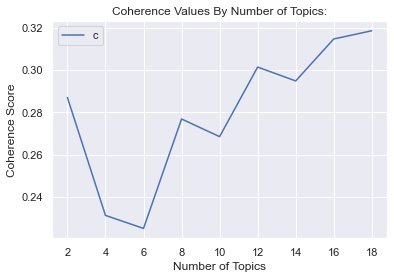

In [114]:
# run function for accommodation reviews
results(accom_dict_big,accom_bow_big,accom_nouns_bigrams,2,20,2)

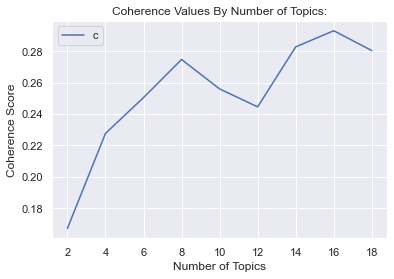

In [115]:
# run function for food reviews
results(food_dict_big,food_bow_big,food_nouns_bigrams,2,20,2)

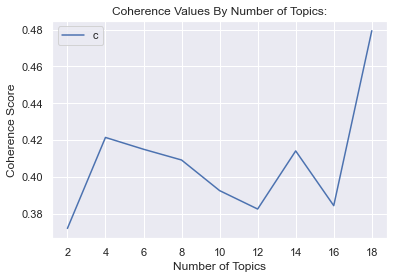

In [116]:
# run function for attraction reviews
results(attract_dict_big,attract_bow_big,attract_nouns_bigrams,2,20,2)

In [267]:
# Rerun models with the suggested number of topics
lda_accom_2 = lda(accom_bow_big, accom_dict_big,8)
lda_food_2 = lda(food_bow_big, food_dict_big,8)
lda_attract_2 = lda(attract_bow_big, attract_dict_big,4)

In [268]:
average_metrics(lda_accom_2,accom_bow_big)

Average Coherence: -2.5168012039683236
Average Perplexity: -8.204771297830003


In [269]:
average_metrics(lda_food_2,food_bow_big)

Average Coherence: -2.8605940271317296
Average Perplexity: -8.334313535966125


In [270]:
average_metrics(lda_attract_2,attract_bow_big)

Average Coherence: -12.54197349623896
Average Perplexity: -6.8459528976502755


Running the coherence function over 2 to 20 topics where the coherence peaks before dipping down. The highest coherence doesn't necessarily product the most sensible topics. The key is to get a balance where there is not too much overlap of words across topics.

In [142]:
#https://stackoverflow.com/questions/37570696/how-to-monitor-convergence-of-gensim-lda-model
#import logging
#logging.basicConfig(filename='gensim.log',
                   # format="%(asctime)s:%(levelname)s:%(message)s",
                    #level=logging.INFO)

In [280]:
# Running the models again with the suggested number of topics and examining the output
# Run models for each category
num_topics_accom = 8
num_topics_food = 8
num_topics_attract = 4

lda_accom_2 = lda(accom_bow_big, accom_dict_big,num_topics = num_topics_accom)
lda_food_2 = lda(food_bow_big, food_dict_big,num_topics = num_topics_food)
lda_attract_2 = lda(attract_bow_big, attract_dict_big,num_topics_attract)

In [281]:
# Incomment to run
lda_accom_2.show_topics(formatted = False)
#lda_food_2.show_topics(formatted = False)
#lda_attract_2.show_topics(formatted = False)

[(0,
  [('room', 0.011162375),
   ('hotel', 0.009989349),
   ('night', 0.009659977),
   ('area', 0.008304661),
   ('staff', 0.008031319),
   ('experience', 0.007781453),
   ('weekend', 0.0074831937),
   ('place', 0.00732101),
   ('breakfast', 0.0058746957),
   ('water', 0.004969715)]),
 (1,
  [('room', 0.008555751),
   ('hotel', 0.00800062),
   ('food', 0.0076198797),
   ('way', 0.0072251614),
   ('pool', 0.006763415),
   ('resort', 0.0064189476),
   ('price', 0.005659496),
   ('night', 0.005456781),
   ('service', 0.005227361),
   ('bar', 0.004522683)]),
 (2,
  [('room', 0.012078229),
   ('night', 0.008049433),
   ('food', 0.0071472186),
   ('stay', 0.0065904227),
   ('staff', 0.00560845),
   ('breakfast', 0.005436693),
   ('hotel', 0.005187357),
   ('restaurant', 0.00450794),
   ('arm', 0.0042456016),
   ('everything', 0.0041873255)]),
 (3,
  [('room', 0.00971707),
   ('family', 0.008006983),
   ('hotel', 0.007660895),
   ('floor', 0.0066080107),
   ('service', 0.006273062),
   ('pla

Lots of overlap in the topics here which shows the model is not isolating the topics well

In [282]:
lda_vis_accom2 = gensimvis.prepare(lda_accom_2,accom_bow_big, accom_dict_big)
lda_vis_food2 = gensimvis.prepare(lda_food_2, food_bow, food_dict_big)
lda_vis_attract2 = gensimvis.prepare(lda_attract_2, attract_bow, attract_dict_big)

In [287]:
# Uncomment to run
#lda_vis_accom2
#lda_vis_food2
lda_vis_attract2

PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
0      0.054 -0.065       1        1 33.948
3     -0.091 -0.028       2        1 31.556
1     -0.001  0.067       3        1 17.316
2      0.038  0.027       4        1 17.179, topic_info=           Term  Freq  Total Category  logprob  loglift
92        thing 4.000  4.000  Default   30.000   30.000
498       class 3.000  3.000  Default   29.000   29.000
309     machine 3.000  3.000  Default   28.000   28.000
288    car_park 8.000  8.000  Default   27.000   27.000
506  membership 2.000  2.000  Default   26.000   26.000
..          ...   ...    ...      ...      ...      ...
143       staff 1.255 10.188   Topic4   -5.092   -0.333
273     service 1.053  3.910   Topic4   -5.267    0.450
161       floor 1.079  5.124   Topic4   -5.243    0.203
171  food_drink 1.013  3.085   Topic4   -5.306    0.648
77       course 1.017  3.917   Topic4   -5.302    0.412

[249 rows x 6 columns], token_table=      Topic  Freq    Term
term                     
45        1 0.312   adult
45        2 0.312   adult
45        3 0.312   adult
435       2 0.665     ann
342       3 0.568  arcade
...     ...   ...     ...
164       2 0.244    work
164       4 0.244    work
75        1 0.325    year
75        2 0.650    year
235       2 0.665     yes

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

# Section 5: NMF

In [289]:
# Function to run NMF Model
def nmf(corpus, dictionary,num_topics):
    nmf_model = GensimNmf(corpus = corpus, id2word = dictionary,num_topics = num_topics)
    return nmf_model

In [290]:
# run function for each category
nmf_accom = nmf(accom_bow_big, accom_dict_big,8)
nmf_food = nmf(food_bow_big, food_dict_big,8)
nmf_attract = nmf(attract_bow_big, attract_dict_big,4)

In [291]:
nmf_accom_topics = nmf_accom.show_topics(formatted = False)
nmf_food_topics = nmf_food.show_topics(formatted = False)
nmf_attract_topics = nmf_attract.show_topics(formatted = False)

In [292]:
nmf_accom_topics

[(0,
  [('room', 0.02734370934932846),
   ('people', 0.01558782124346703),
   ('breakfast', 0.011831003668998115),
   ('staff', 0.011269241663281651),
   ('queue', 0.011046639510314003),
   ('minute', 0.010490556549472037),
   ('night', 0.009864204900651024),
   ('slide', 0.009209879101386244),
   ('hotel', 0.009078134412613405),
   ('table', 0.00817599251740362)]),
 (1,
  [('room', 0.03137337111333814),
   ('show', 0.01584619148166152),
   ('photo', 0.012368427710625712),
   ('kid', 0.01202115826804132),
   ('floor', 0.01017771031214309),
   ('stay', 0.008871482102614868),
   ('break', 0.008746492619619455),
   ('picture', 0.007971943761682173),
   ('someone', 0.007232406313071182),
   ('thing', 0.0067336824352134585)]),
 (2,
  [('way', 0.02067590646200767),
   ('weekend', 0.013670556802068036),
   ('slide', 0.013142349515590153),
   ('queue', 0.012405126890170709),
   ('stage', 0.012090563489924771),
   ('daughter', 0.01075934623566494),
   ('lot', 0.010048928570080337),
   ('people'

In [293]:
nmf_food_topics

[(0,
  [('food', 0.039511078489458666),
   ('restaurant', 0.02175701834258402),
   ('night', 0.010545946768727488),
   ('place', 0.01043486466941538),
   ('staff', 0.010010863818723993),
   ('bar', 0.008656422387248784),
   ('breakfast', 0.007687389704479527),
   ('service', 0.007172743838026125),
   ('waitress', 0.006942582464620102),
   ('part', 0.006662484235694442)]),
 (1,
  [('place', 0.012885962444843245),
   ('food', 0.011576548415350245),
   ('table', 0.011111092718786183),
   ('pizza', 0.007879887708882368),
   ('thing', 0.0069079793832259075),
   ('cook', 0.006180516280347534),
   ('meat', 0.006095882177215444),
   ('food_service', 0.006051091971699235),
   ('min', 0.005911665966347617),
   ('chip', 0.005661932217474927)]),
 (2,
  [('food', 0.020338823820198113),
   ('bit', 0.01696839985988314),
   ('lunch', 0.016597632638200514),
   ('service', 0.013169095771480134),
   ('carvery', 0.00991993484738692),
   ('taste', 0.009915198304779155),
   ('visit', 0.00866497679839766),
 

In [294]:
nmf_attract_topics

[(0,
  [('class', 0.02437819253328505),
   ('room', 0.02374518418189398),
   ('visit', 0.021545280715997837),
   ('membership', 0.01952948164738283),
   ('week', 0.019344908343471183),
   ('floor', 0.014925329743075628),
   ('thing', 0.01305038461204495),
   ('price', 0.012929275655261054),
   ('hour', 0.012461390461790185),
   ('u', 0.011047105553577224)]),
 (1,
  [('room', 0.04024400698719924),
   ('floor', 0.02580060667236925),
   ('money', 0.023253957239266126),
   ('kid', 0.02012391879069249),
   ('ground', 0.018639649037476225),
   ('toilet', 0.016761940199775362),
   ('family', 0.014982386241130081),
   ('car_park', 0.01473345867928697),
   ('spa', 0.014336381638853486),
   ('lot', 0.013177303194840603)]),
 (2,
  [('area', 0.02375216604150485),
   ('month', 0.021113786810811733),
   ('conversation', 0.018764834072907854),
   ('machine', 0.016128418746997296),
   ('staff', 0.014176232334666621),
   ('breakfast', 0.013138238674003369),
   ('trip', 0.012420201193149558),
   ('porti

# Section 6: Model Evaluation

In [295]:
# Function to get coherence for each model on the top ten topic words
def evaluate(model,model_topics,text,dictionary):
    model_topics = model.show_topics(formatted = False)
    model_topics = [[word for word, prob in topic] for topicid,topic in model_topics]
    model_coherence = CoherenceModel(topics = model_topics[:10],texts = text, dictionary = dictionary,window_size = 10).get_coherence()
    return model_coherence

In [296]:
# Rerun the LSI with the same numbers of topics as the other two models
lsi_accom = lsi(accom_bow_big, 8,accom_dict_big)
lsi_food = lsi(food_bow_big, 8, food_dict_big)
lsi_attract = lsi(attract_bow_big, 4, attract_dict_big)

In [297]:
# Run function for LSI
lsi_accom_eval = evaluate(lsi_accom,lsi_accom_topics,accom_nouns_bigrams,accom_dict_big)
lsi_food_eval = evaluate(lsi_food,lsi_food_topics,food_nouns_bigrams,food_dict_big)
lsi_attract_eval = evaluate(lsi_attract,lsi_attract_topics,attract_nouns_bigrams, attract_dict_big)

In [298]:
# Run function for LDA
lda_accom_eval = evaluate(lda_accom_2,lda_accom_topics,accom_nouns_bigrams,accom_dict_big)
lda_food_eval = evaluate(lda_food_2,lda_food_topics,food_nouns_bigrams,food_dict_big)
lda_attract_eval = evaluate(lda_attract_2,lda_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [299]:
# Run function for NMF
nmf_accom_eval = evaluate(nmf_accom,nmf_accom_topics,accom_nouns_bigrams,accom_dict_big)
nmf_food_eval = evaluate(nmf_food, nmf_food_topics,food_nouns_bigrams,food_dict_big)
nmf_attract_eval = evaluate(nmf_attract,nmf_attract_topics,attract_nouns_bigrams,attract_dict_big)

In [300]:
def graph(coherences,indices,name):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    fig, ax = plt.subplots()
    ax.set_facecolor("White")
    ax.bar(x,coherences,width = 0.5,tick_label=indices,align = 'center')
    ax.set_title("Topic Models Average Coherence Comparison: " + name)
    ax.set_xlabel('Models')
    ax.set_ylabel('Coherence Value')

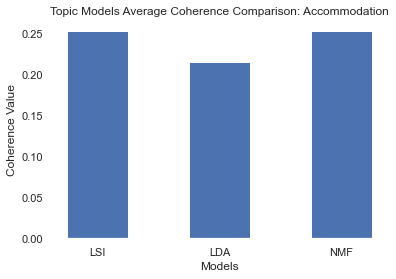

In [301]:
graph([lsi_accom_eval, lda_accom_eval, nmf_accom_eval],['LSI','LDA','NMF'],"Accommodation")

LSI and NMF very similar

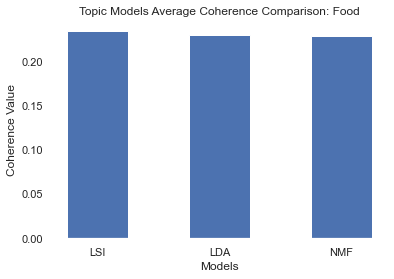

In [302]:
graph([lsi_food_eval, lda_food_eval, nmf_food_eval],['LSI','LDA','NMF'],"Food")

NMF has the best results

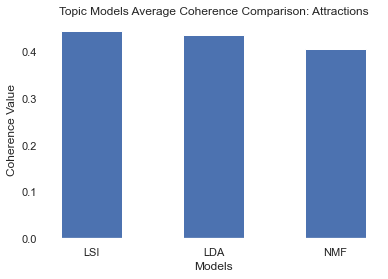

In [303]:
graph([lsi_attract_eval, lda_attract_eval, nmf_attract_eval],['LSI','LDA','NMF'],"Attractions")

LSI seems to have the best result for attractions

# Section 7: NMF Using SciKit Learn Model

NMF for accommodation and food reviews

In [205]:
#Convert list of strings to a string for training set
accom_df["joined"] = accom_df.nouns.apply(lambda x:' '.join(x))
food_df["joined"] = food_df.nouns.apply(lambda x:' '.join(x))
attract_df["joined"] = attract_df.nouns.apply(lambda x:' '.join(x))

In [1065]:
#accom_df["nouns"] = accom_df["nouns"].apply(lambda x: ast.literal_eval(x))
#food_df["nouns"] = food_df["nouns"].apply(lambda x: ast.literal_eval(x))
#attract_df["nouns"] = attract_df["nouns"].apply(lambda x: ast.literal_eval(x))

In [206]:
# Function to transform to bow and tfidf models - Exclude words occurring in less # than 2 documents and in more than 98%
# of documents and to include unigrams and bigrams

def transform(df):
    sw = ["le","hour","place","lot","bit","get","side","night","stay","week","hour","day","home","weekend",
          "family","people","child","kid","area"]
    countvectorizer = CountVectorizer(stop_words = sw,max_features = 5000,max_df = 0.95, min_df = 3,ngram_range=(1,3))
    tf_idf_vectorizer = TfidfVectorizer(stop_words = sw,max_df = 0.95,min_df = 3,ngram_range=(1, 3))
    vector1 = countvectorizer.fit_transform(df)
    vector2 = tf_idf_vectorizer.fit_transform(df)
    return countvectorizer,tf_idf_vectorizer,vector1,vector2

In [207]:
# Create vectorizer and tfidf vectorizer objects
countvectorizer_accom,tf_idf_vectorizer_accom,vector1_accom,vector2_accom = transform(accom_df["joined"])
countvectorizer_food,tf_idf_vectorizer_food,vector1_food,vector2_food = transform(food_df["joined"])
countvectorizer_attract,tf_idf_vectorizer_attract,vector1_attract,vector2_attract = transform(attract_df["joined"])

In [208]:
# NMF function - alpha set to 1.0 for regularization and max_iter to 1000 rather than default of 200, as topics are fuzzy. Both solvers were tried 'Cd' and
# 'Mu' to see which worked better

def nmf(vectorizer,vector,num_topics):
    nmf_model = NMF(n_components = num_topics, 
                    solver="mu",
                    init = 'nndsvd',
                    alpha = 1.0,
                    beta_loss='kullback-leibler',
                    max_iter = 1000,
                    random_state = 0)
    vec_object = nmf_model.fit(vector)
    doc_topics = vec_object.transform(vector)
            
    # Extract features and weights
    feature_names = np.array(vectorizer.get_feature_names())
    weights = nmf_model.components_
    
    # Extract topics and weights
    feature_names = np.array(vectorizer.get_feature_names())
    feature_idxs = np.argsort(-weights)#[:,:15]
    topics = [feature_names[idx] for idx in feature_idxs]
    topics = pd.DataFrame(topics)
    
           
    return doc_topics,topics

# Section 8: Accommodation - NMF Model

### Countvectorizer

In [224]:
# Run function for accommodation
num_topics = 5
accom_count,accom_topics = nmf(countvectorizer_accom,vector1_accom,num_topics)
topics_count_accom = accom_topics.T
topics_count_accom.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_count_accom.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,room,pool,hotel,apartment,food
1,breakfast,staff,staff,door,meal
2,hotel,floor,breakfast,service,restaurant
3,bathroom,way,location,accommodation,lunch
4,staff,show,thing,resort,pub
5,bed,holiday,asunder,park,site
6,room room,slide,service,year,staff
7,floor,resort,reception,pool,service
8,location,entertainment,staff room,car,experience
9,water,apartment,nothing,entertainment,menu


In [221]:
# Apply topics to documents for the countvectorizer model 
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_accom_count = pd.DataFrame(accom_count, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
#topics_per_doc_accom.columns = ["Staff","Room","Hotel","Food","Facilities","Entertainment"]
topics_per_doc_accom_count["Top"] = topics_per_doc_accom_count.idxmax(axis="columns")
topics_per_doc_accom_count.head()

,T1,T2,T3,T4,T5,T6,T7,Top
0,0.365,0.000,0.000,0.000,0.000,0.174,0.000,T1
1,0.643,0.013,0.000,0.000,0.000,0.014,0.179,T1
2,0.072,0.000,0.000,0.234,0.000,0.009,0.000,T4
3,0.619,0.000,0.000,0.000,0.198,0.000,0.000,T1
4,0.000,0.000,0.000,0.000,0.395,0.000,0.000,T5


In [222]:
# Add the most likely topic to the review
predict_count_accom = pd.DataFrame(accom_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
accom_count_top = topics_per_doc_accom_count["Top"]
accom_predict_count = pd.concat([predict_count_accom,accom_count_top],axis = 1,ignore_index = True)
accom_predict_count.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
accom_predict_count.head()

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,245,Bognor,Accommodation,0,central room excellent view could see sea room...,T1
1,209,Littlehampton,Accommodation,1,not used lived area year fact daughter worked ...,T1
2,28,Bognor,Accommodation,0,easter break day stayed rockpool xu apartment ...,T4
3,365,Arundel,Accommodation,0,fantastic pub tucked away top asunder high str...,T1
4,389,Arundel,Accommodation,1,charging top price low quality food buttermilk...,T5


### TF-IDF Vectorizer

In [225]:
#Run function for accommodation - tfidf model 
accom_tfidf,accom_topics_tfidf = nmf(tf_idf_vectorizer_accom,vector2_accom,num_topics)
topics_tfidf_accom = accom_topics_tfidf.T
topics_tfidf_accom.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_tfidf_accom.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,room,pool,food,hotel,staff
1,breakfast,apartment,pub,service,location
2,bathroom,accommodation,lunch,reception,breakfast
3,staff,resort,restaurant,staff hotel,site
4,view,entertainment,meal,smell,visit
5,room room,break,staff,building,town
6,bed,floor,service,hotel room,asunder
7,problem,adult,experience,bed,football
8,window,show,quality,need,nothing
9,value,food,menu,bedroom,beach


In [227]:
# Apply topics to documents
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_accom_tfidf = pd.DataFrame(accom_tfidf, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
topics_per_doc_accom_tfidf.columns = ["Room","Facilities & Entertainment","Food","Hotel General","Staff"]
topics_per_doc_accom_tfidf["Top"] = topics_per_doc_accom_tfidf.idxmax(axis="columns")
topics_per_doc_accom_tfidf.head()

,Room,Facilities & Entertainment,Food,Hotel General,Staff,Top
0,0.174,0.005,0.000,0.000,0.000,Room
1,0.182,0.004,0.000,0.001,0.011,Room
2,0.000,0.122,0.000,0.000,0.044,Facilities & Entertainment
3,0.203,0.000,0.020,0.000,0.000,Room
4,0.000,0.000,0.195,0.000,0.000,Food


In [228]:
# Add the most likely topic to the review
predict_tfidf_accom = pd.DataFrame(accom_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
accom_tfidf_top = topics_per_doc_accom_tfidf["Top"]
accom_predict_tfidf = pd.concat([predict_tfidf_accom,accom_tfidf_top],axis = 1,ignore_index = True)
accom_predict_tfidf.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
accom_predict_tfidf.head(6)

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,245,Bognor,Accommodation,0,central room excellent view could see sea room...,Room
1,209,Littlehampton,Accommodation,1,not used lived area year fact daughter worked ...,Room
2,28,Bognor,Accommodation,0,easter break day stayed rockpool xu apartment ...,Facilities & Entertainment
3,365,Arundel,Accommodation,0,fantastic pub tucked away top asunder high str...,Room
4,389,Arundel,Accommodation,1,charging top price low quality food buttermilk...,Food
5,288,Bognor,Accommodation,1,food horror show arrived back holiday royal no...,Food


# Section 9: Food - NMF Model

### Countvectorizer

In [229]:
# Run function for accommodation
num_topics = 5
food_count,food_topics = nmf(countvectorizer_food,vector1_food,num_topics)
topics_count_food = food_topics.T
topics_count_food.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_count_food.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,food,chip,staff,meal,order
1,service,portion,bar,service,pizza
2,staff,meal,breakfast,dinner,minute
3,restaurant,fish,coffee,roast,drink
4,lunch,burger,table,lunch,customer
5,menu,pie,tea,waitress,wait
6,value,sauce,member,restaurant,waitress
7,food service,sausage,visit,plate,min
8,pub,cod,glass,visit,delivery
9,visit,menu,menu,starter,food order


In [230]:
# Apply topics to documents for the countvectorizer model 
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_food_count = pd.DataFrame(food_count, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
#topics_per_doc_accom.columns = ["Staff","Room","Hotel","Food","Facilities","Entertainment"]
topics_per_doc_food_count["Top"] = topics_per_doc_food_count.idxmax(axis="columns")
topics_per_doc_food_count.head()

,T1,T2,T3,T4,T5,Top
0,0.000,0.000,0.566,0.000,0.000,T3
1,0.097,0.000,0.221,0.008,0.000,T3
2,0.144,0.000,0.000,0.037,0.000,T1
3,0.000,0.000,0.065,0.000,0.157,T5
4,0.033,0.000,0.266,0.060,0.260,T3


In [231]:
# Add the most likely topic to the review
predict_count_food = pd.DataFrame(food_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
food_count_top = topics_per_doc_food_count["Top"]
food_predict_count = pd.concat([predict_count_food,food_count_top],axis = 1,ignore_index = True)
food_predict_count.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
food_predict_count.head()

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,1099,Littlehampton,Food,0,nice pub fare ale franchise establishment them...,T3
1,1294,Bognor,Food,0,fantastic chose celebrate daughter birthday fa...,T3
2,583,Arundel,Food,0,awesome eating date several time great service...,T1
3,411,Littlehampton,Food,1,saturday afternoon drink bad experience eating...,T5
4,794,Littlehampton,Food,1,disappointment local harvester shut looking fo...,T3


### TF-IDF Vectorizer

In [232]:
#Run function for accommodation - tfidf model 
food_tfidf,food_topics_tfidf = nmf(tf_idf_vectorizer_food,vector2_food,num_topics)
topics_tfidf_food = food_topics_tfidf.T
topics_tfidf_food.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_tfidf_food.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,restaurant,chip,service,staff,order
1,meal,portion,food,food,breakfast
2,food,fish,food service,lunch,customer
3,visit,burger,service food,staff food,drink
4,staff,pie,food food,food staff,minute
5,bar,sauce,dinner,menu,service
6,menu,cod,restaurant food,choice,wait
7,friend,fish chip,portion,coffee,coffee
8,roast,sausage,thank,pub,waitress
9,table,meal,thai,value,customer service


In [234]:
# Apply topics to documents
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_food_tfidf = pd.DataFrame(food_tfidf, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
topics_per_doc_food_tfidf.columns = ["Restaurant General","Food","Food Service","Staff Generally","Ordering"]
topics_per_doc_food_tfidf["Top"] = topics_per_doc_food_tfidf.idxmax(axis="columns")
topics_per_doc_food_tfidf.head()

,Restaurant General,Food,Food Service,Staff Generally,Ordering,Top
0,0.084,0.000,0.000,0.081,0.000,Restaurant General
1,0.088,0.000,0.000,0.034,0.000,Restaurant General
2,0.006,0.000,0.193,0.000,0.000,Food Service
3,0.026,0.000,0.000,0.000,0.096,Ordering
4,0.054,0.000,0.000,0.000,0.120,Ordering


In [235]:
# Add the most likely topic to the review
predict_tfidf_food = pd.DataFrame(food_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
food_tfidf_top = topics_per_doc_food_tfidf["Top"]
food_predict_tfidf = pd.concat([predict_tfidf_food,food_tfidf_top],axis = 1,ignore_index = True)
food_predict_tfidf.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
food_predict_tfidf.head(6)

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,1099,Littlehampton,Food,0,nice pub fare ale franchise establishment them...,Restaurant General
1,1294,Bognor,Food,0,fantastic chose celebrate daughter birthday fa...,Restaurant General
2,583,Arundel,Food,0,awesome eating date several time great service...,Food Service
3,411,Littlehampton,Food,1,saturday afternoon drink bad experience eating...,Ordering
4,794,Littlehampton,Food,1,disappointment local harvester shut looking fo...,Ordering
5,1229,Littlehampton,Food,1,shocking given place chance across year travel...,Ordering


In [1075]:
# Run function for food
num_topics = 5
attract_count,attract_topics = nmf(countvectorizer_attract,vector1_attract,num_topics)
topics_count_attract = attract_topics.T
topics_count_attract.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_count_attract.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,park,garden,food,staff,toilet
1,car,history,money,ground,room
2,car park,trip,beach,play,floor
3,shop,visit,value,year,facility
4,machine,look,way,visit,pool
5,entrance,part,minute,site,need
6,street,access,work,month,dirty
7,fruit,cafe,thing,service,hand
8,littlehampton,round,view,time,class
9,corner,tour,water,customer,membership


In [1076]:
# Apply topics to documents for the countvectorizer model 
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_attract_count = pd.DataFrame(attract_count, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
#topics_per_doc_accom.columns =
topics_per_doc_attract_count["Top"] = topics_per_doc_attract_count.idxmax(axis="columns")
topics_per_doc_attract_count.head()

,T1,T2,T3,T4,T5,Top
0,0.000,0.000,0.000,0.000,0.000,T1
1,0.000,0.000,0.095,0.150,0.000,T4
2,0.000,0.000,0.188,0.000,0.000,T3
3,0.000,0.000,0.188,0.000,0.000,T3
4,0.000,0.101,0.106,0.164,0.069,T4


In [1077]:
# Add the most likely topic to the review
predict_count_attract = pd.DataFrame(attract_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
attract_count_top = topics_per_doc_attract_count["Top"]
attract_predict_count = pd.concat([predict_count_attract,attract_count_top],axis = 1,ignore_index = True)
attract_predict_count.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
attract_predict_count.head()

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,760,Arundel,Attract,1,still pricey yes open yes café de-cluttered we...,T1
1,760,Arundel,Attract,1,portable heater useless staff member admitted ...,T4
2,760,Arundel,Attract,1,coffee served mean little cup way overpriced,T3
3,760,Arundel,Attract,1,may worthy organisation delusion superiority s...,T3
4,836,Bognor,Attract,1,not bother big refurbishment swimming pool per...,T4


In [1078]:
#Run function for accommodation - tfidf model 
attract_tfidf,attract_topics_tfidf = nmf(tf_idf_vectorizer_attract,vector2_attract,num_topics)
topics_tfidf_attract = attract_topics_tfidf.T
topics_tfidf_attract.columns = ["Topic" + str(i) for i in range(1,num_topics+1)]
topics_tfidf_attract.head(10)

,Topic1,Topic2,Topic3,Topic4,Topic5
0,staff,garden,food,park,room
1,history,visit,money,ground,toilet
2,play,trip,beach,car,pool
3,price,look,way,site,floor
4,shop,walk,value,month,facility
5,need,half,minute,year,water
6,snack,tour,view,car park,access
7,cinema,cost,party,entrance,reason
8,customer,pay,coffee,machine,membership
9,service,kitchen,cafe,see,dirty


In [1079]:
# Apply topics to documents
pd.options.display.float_format = '{:,.3f}'.format
topics_per_doc_attract_tfidf = pd.DataFrame(attract_tfidf, columns = ['T'+ str(i) for i in range(1,num_topics+1)])
topics_per_doc_attract_tfidf.columns = ["Staff","Experience","Food and Value","Car Parking","Facilities"]
topics_per_doc_attract_tfidf["Top"] = topics_per_doc_attract_tfidf.idxmax(axis="columns")
topics_per_doc_attract_tfidf.head()

,Staff,Experience,Food and Value,Car Parking,Facilities,Top
0,0.000,0.000,0.000,0.000,0.000,Staff
1,0.216,0.000,0.000,0.000,0.000,Staff
2,0.000,0.000,0.173,0.000,0.000,Food and Value
3,0.000,0.000,0.172,0.000,0.000,Food and Value
4,0.000,0.076,0.048,0.072,0.099,Facilities


In [1080]:
# Add the most likely topic to the review
predict_tfidf_attract = pd.DataFrame(attract_df[["OrgInd","Town","Category","Score","Sent_clean"]]).reset_index(drop = True)
attract_tfidf_top = topics_per_doc_attract_tfidf["Top"]
attract_predict_tfidf = pd.concat([predict_tfidf_attract,attract_tfidf_top],axis = 1,ignore_index = True)
attract_predict_tfidf.columns = ["OrgInd","Town","Category","Score","Sent_clean","Top Topic"]
attract_predict_tfidf.head(6)

,OrgInd,Town,Category,Score,Sent_clean,Top Topic
0,760,Arundel,Attract,1,still pricey yes open yes café de-cluttered we...,Staff
1,760,Arundel,Attract,1,portable heater useless staff member admitted ...,Staff
2,760,Arundel,Attract,1,coffee served mean little cup way overpriced,Food and Value
3,760,Arundel,Attract,1,may worthy organisation delusion superiority s...,Food and Value
4,836,Bognor,Attract,1,not bother big refurbishment swimming pool per...,Facilities
5,711,Arundel,Attract,0,nice walk lot birdlife enjoy park dominated lake,Car Parking


# Section 12: LDA with SciKit Learn Implementation on the Nouns Data


## Food

There is conflicting research using tf-idf or counts for LDA although Blei et al suggest tf-idf is not necessary due to LDA being a probabilistic model. Therefore the countvectorizer is used.

In [1144]:
# Look at a sample of the nouns data for food
food_df.joined.head()

0                   time review food staff
1    anyone price portion size get quality
2                  shame shame family meal
3                               time money
4                           bill tape dish
Name: joined, dtype: object

In [1453]:
# Create countvectorizer object function

def transform_lda(df):
    sw = []
    countvectorizer = CountVectorizer(stop_words = sw,max_features = 5000,max_df = 0.90, min_df = 5,ngram_range=(1,2))
    tfidf_vectorizer = TfidfVectorizer(stop_words = sw,max_df = 0.90,min_df = 3,ngram_range=(1, 2))
    count_vec = countvectorizer.fit_transform(df)
    tfidf_vec = tfidf_vectorizer.fit_transform(df)
    return countvectorizer,count_vec,tfidf_vectorizer, tfidf_vec

In [1454]:
# Apply function to food words
countvectorizer_food, countvec_food, tfidf_vectorizer_food,tfidfvec_food = transform_lda(food_df.joined)

In [1455]:
# Create and fit the LDA models
lda_count = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter = 20,learning_method = "online", random_state = 42)
lda_count.fit(countvec_food)

lda_tfidf = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter = 20,learning_method = "online", random_state = 42)
lda_tfidf.fit(tfidfvec_food)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_components=5,
                          n_jobs=-1, random_state=42)

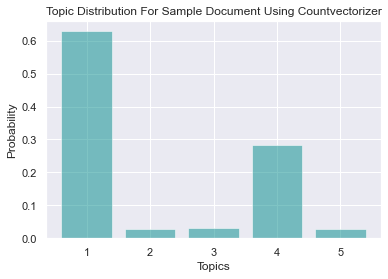

In [1429]:
# Looking at topic range for a sample document using the countvectorizer model
topics = [1,2,3,4,5]
dtm_count = pd.DataFrame(lda_count.transform(countvec_food), columns = topics)
probs = list(dtm_count.iloc[0])
plt.bar(topics, probs, align='center', alpha=0.5, color = "darkcyan")
plt.xticks(topics)
plt.ylabel('Probability')
plt.xlabel("Topics")
ax = plt.title('Topic Distribution For Sample Document Using Countvectorizer')

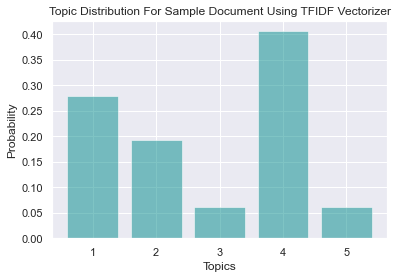

In [1456]:
# Looking at topic range for the same sample document using the tfidf vectorizer model
topics = [1,2,3,4,5]
dtm_tfidf = pd.DataFrame(lda_tfidf.transform(tfidfvec_food), columns = topics)
probs = list(dtm_tfidf.iloc[0])
plt.bar(topics, probs, align='center', alpha=0.5, color = "darkcyan")
plt.xticks(topics)
plt.ylabel('Probability')
plt.xlabel("Topics")
ax = plt.title('Topic Distribution For Sample Document Using TFIDF Vectorizer')

## Try the Countvectorizer Model First

In [1432]:
# Create document topic matrix - apply top topic and ensure that values sum to 1
dtm_count["Topic"] = dtm_count.idxmax(axis = 1)
dtm_count["Prob"] = dtm_count.iloc[:,0:5].sum(axis=1)

In [1434]:
dtm_count.head()

,1,2,3,4,5,Topic,Prob
0,0.629,0.029,0.030,0.284,0.029,1,1.000
1,0.775,0.025,0.025,0.025,0.150,1,1.000
2,0.033,0.033,0.867,0.033,0.033,3,1.000
3,0.733,0.067,0.067,0.067,0.067,1,1.000
4,0.400,0.067,0.067,0.067,0.400,1,1.000


In [1435]:
# Obtain value counts per topic - note: we don't know what the topics are at this point
x = pd.DataFrame(dtm_count["Topic"].value_counts())
x.T

,5,1,3,2,4
Topic,1522,1395,1370,1105,953


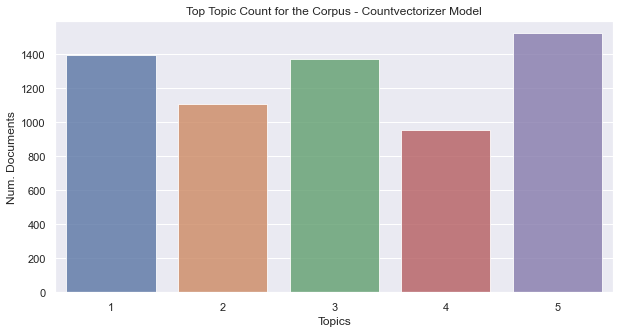

In [1436]:
# Plot top topics for all documents
plt.figure(figsize=(10,5))
sns.barplot(x.index, x.Topic, alpha=0.8)
plt.title("Top Topic Count for the Corpus - Countvectorizer Model")
plt.ylabel("Num. Documents")
ax = plt.xlabel("Topics")

In [1437]:
# Transform weights to probabilities that sum to one not done automatically in Scikit Learn
wtm_count = lda_count.components_
wtm_count/=wtm_count.sum(axis = 1)[:,np.newaxis]
wtm_count[1].sum()

1.0

In [1439]:
# Function to print out top words (code from Scikit learn documentation)

n_top_words = 10

def top_words(lda_count, feature_names, n_top_words):
    for topic_idx, topic in enumerate(lda_count.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [1440]:
# Run function
feature_names = countvectorizer_food.get_feature_names()
top_words(lda_count, feature_names, n_top_words)

Topic #0: food menu drink value portion people dinner price plate money
Topic #1: chip table restaurant meal way year steak order side home
Topic #2: staff service meal food pub customer family experience minute bar
Topic #3: night roast burger staff potato food choice wine evening party
Topic #4: food lunch place service visit friend quality order restaurant food service



In [1441]:
# Dataframe to show word-topic probability distributions for each word over 
# every topic with total probabilities summing to one
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5"]
df_word_prob = pd.DataFrame(wtm_count, columns = [countvectorizer_food.get_feature_names()], index = ind)
df_word_prob["Prob"] = df_word_prob.iloc[:,:].sum(axis=1)
df_word_prob.head()

,absolute,addition,adult,adult child,advance,advisor,afternoon,afternoon tea,afterwards,age,...,world,worth,wow,year,yes,yesterday,yorkshire,yorkshire pudding,yummy,Prob
Topic1,0.000,0.001,0.004,0.002,0.001,0.002,0.000,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,1.000
Topic2,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,...,0.000,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.000,1.000
Topic3,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,...,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,1.000
Topic4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010,...,0.000,0.002,0.001,0.000,0.002,0.000,0.006,0.002,0.000,1.000
Topic5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,1.000


In [1442]:
# Create word topic matrix dataframe

# Sort top ten words by weight and then use to look up words
all_words = np.array(feature_names)
topic_top = []
for topic_weights in wtm_count:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))
    
# Create topic - keywords Dataframe
cols = ["Word1","Word2","Word3","Word4","Word5","Word6","Word7","Word8","Word9","Word10"]
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

topic_word_matrix_count = pd.DataFrame(topic_top, columns = cols, index = ind)                                  
topic_word_matrix_count


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10
Topic1,food,menu,drink,value,portion,people,dinner,price,plate,money
Topic2,chip,table,restaurant,meal,way,year,steak,order,side,home
Topic3,staff,service,meal,food,pub,customer,family,experience,minute,bar
Topic4,night,roast,burger,staff,potato,food,choice,wine,evening,party
Topic5,food,lunch,place,service,visit,friend,quality,order,restaurant,food service


## Try the TF-IDF Vectorizer Model 

In [1457]:
# Create document topic matrix - apply top topic and ensure that values sum to 1
dtm_tfidf["Topic"] = dtm_tfidf.idxmax(axis = 1)
dtm_tfidf["Prob"] = dtm_tfidf.iloc[:,0:5].sum(axis=1)

In [1458]:
# Obtain value counts per topic - note: we don't know what the topics are at this point
y = pd.DataFrame(dtm_tfidf["Topic"].value_counts())
y.T

,1,3,4,5,2
Topic,1873,1319,1084,1078,991


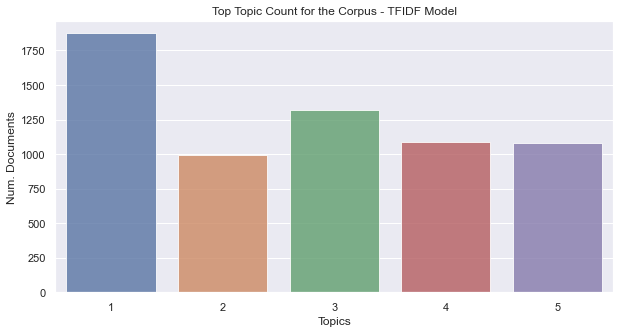

In [1459]:
# Plot top topics for all documents
plt.figure(figsize=(10,5))
sns.barplot(y.index, y.Topic, alpha=0.8)
plt.title("Top Topic Count for the Corpus - TFIDF Model")
plt.ylabel("Num. Documents")
ax = plt.xlabel("Topics")

In [1460]:
# Transform weights to probabilities that sum to one not done automatically in Scikit Learn
wtm_tfidf = lda_tfidf.components_
wtm_tfidf/=wtm_tfidf.sum(axis = 1)[:,np.newaxis]
wtm_tfidf[1].sum()

1.0

In [1461]:
# Run function
feature_names_tfidf = tfidf_vectorizer_food.get_feature_names()
top_words(lda_tfidf, feature_names_tfidf, n_top_words)

Topic #0: staff lunch customer experience food service burger value roast menu
Topic #1: service food service visit food time steak tea excellent occasion glass
Topic #2: food meal place table restaurant night portion quality friend family
Topic #3: chip order drink food waitress starter breakfast bit review minute
Topic #4: pub way eat choice coffee price wine lot food manager



In [1462]:
# Dataframe to show word-topic probability distributions for each word over 
# every topic with total probabilities summing to one
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5"]
df_word_prob_tfidf = pd.DataFrame(wtm_tfidf, columns = [tfidf_vectorizer_food.get_feature_names()], index = ind)
df_word_prob_tfidf["Prob"] = df_word_prob_tfidf.iloc[:,:].sum(axis=1)
df_word_prob_tfidf.head()

,absolute,absolute bargain,accommodate,action,activity,ad,addition,address,adult,adult child,...,yes,yesterday,yogurt,yorkshire,yorkshire pud,yorkshire pudding,yorkshire roast,yum,yummy,Prob
Topic1,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.003,0.000,...,0.001,0.000,0.000,0.002,0.000,0.001,0.000,0.000,0.000,1.000
Topic2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
Topic3,0.000,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,...,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
Topic4,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,...,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,1.000
Topic5,0.003,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.002,1.000


In [1463]:
# Create word topic matrix dataframe

# Sort top ten words by weight and then use to look up words
all_words = np.array(feature_names_tfidf)
topic_top = []
for topic_weights in wtm_count:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))
    
# Create topic - keywords Dataframe
cols = ["Word1","Word2","Word3","Word4","Word5","Word6","Word7","Word8","Word9","Word10"]
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

topic_word_matrix_tfidf = pd.DataFrame(topic_top, columns = cols, index = ind)                                  
topic_word_matrix_tfidf

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10
Topic1,coconut,fan,chicken breast,mamma,friend chicken,food quality,chance,garden centre,food wife,finish
Topic2,bit,life,group friend,fab,meal party,memory,la,food food,iceland,delivery food
Topic3,juicy,hour minute,fab,coconut,get attention,cancel,christmas dinner,choice portion,fillet steak,area
Topic4,food atmosphere,harbour,barman,juicy,fritter,coconut,blonde,meat roast,chip service,food order
Topic5,coconut,evening,food terrible,hour minute,mash,course,give,food food,group friend,control


Using TFIDF, the topics are difficult to determine, easily. The countvectorizer model perhaps makes more sense

## Try to Refine the Countvectorizer Model

### Add stopwords, amend the max_df and min_df

In [1515]:
# Define and fit Countvectorizer
sw = ["chip"]
countvectorizer_refined = CountVectorizer(stop_words = sw,max_features = 5000,max_df = 0.98, min_df = 5,ngram_range=(1,3))
countvec_refined = countvectorizer_refined.fit_transform(food_df.joined)

# Fit model
lda_count_refined = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter = 20,learning_method = "online", random_state = 42)
lda_count_refined.fit(countvec_refined)

# Create DTM
topics = [1,2,3,4,5]
dtm_count_refined = pd.DataFrame(lda_count_refined.transform(countvec_refined), columns = topics)
dtm_count_refined["Topic"] = dtm_count_refined.idxmax(axis = 1)
dtm_count_refined["Prob"] = dtm_count_refined.iloc[:,0:5].sum(axis=1)

# Create WTM
wtm_count_refined = lda_count_refined.components_
wtm_count_refined/=wtm_count_refined.sum(axis = 1)[:,np.newaxis]

# Get top words
feature_names_refined = countvectorizer_refined.get_feature_names()
all_words = np.array(feature_names_refined)
topic_top = []
for topic_weights in wtm_count_refined:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))
    
# Create topic - keywords Dataframe
cols = ["Word1","Word2","Word3","Word4","Word5","Word6","Word7","Word8","Word9","Word10"]
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

topic_word_matrix_refined = pd.DataFrame(topic_top, columns = cols, index = ind)                                  
topic_word_matrix_refined

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10
Topic1,service,menu,people,dinner,restaurant,burger,quality,way,bit,manager
Topic2,place,value,experience,choice,plate,money,order,bill,course,waitress
Topic3,customer,table,roast,staff,breakfast,service,minute,bar,drink,starter
Topic4,staff,meal,lunch,pub,family,visit,service,coffee,lot,place
Topic5,restaurant,price,birthday,eat,wife,chef,review,place,pizza,thing


## Hyperparameter Tuning

In [1499]:
# Grid Search topics and learning decay
search_params = {'n_components': [5,10,15,20], 'learning_decay': [.5,.7,.9]}
lda_model = LatentDirichletAllocation(learning_method='online',random_state = 42)
model = GridSearchCV(lda_model, param_grid=search_params)
model.fit(countvec_refined)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20]})

In [1500]:
# Best Model
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(countvec_refined))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -32075.501815450367
Model Perplexity:  596.8428918780614


<AxesSubplot:title={'center':'Learning Decay By Number of Topics - LDA Food Model'}, xlabel='Number of Topics', ylabel='Log Likelihood'>

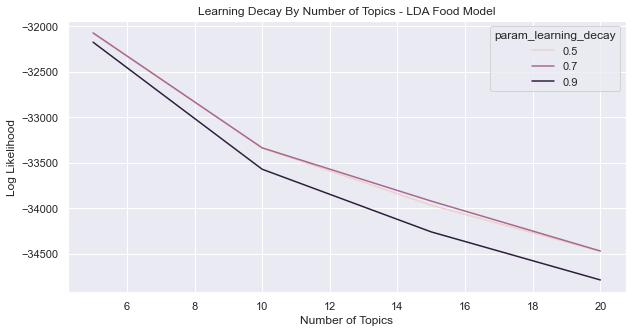

In [1512]:
result = pd.DataFrame(model.cv_results_)
plt.figure(figsize = (10,5))
plt.title("Learning Decay By Number of Topics - LDA Food Model")
plt.xlabel("Number of Topics")
plt.ylabel("Log Likelihood")
sns.lineplot(data = result, x = "param_n_components",y = "mean_test_score",hue = "param_learning_decay")

The log-likelihood seems to fall with increasing numbers of topics which is the opposite of what we might expect. The optimum number of topics is only 5 

In [1522]:
# Create and fit the LDA model
lda_best = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter = 10, learning_method = "online", learning_decay=0.7, random_state = 42)

In [1523]:
lda_best.fit(countvec_refined)

LatentDirichletAllocation(learning_method='online', max_iter=50, n_components=5,
                          n_jobs=-1, random_state=42)

In [1524]:
dtm = pd.DataFrame(lda_best.transform(countvec_refined))
dtm["Topic"] = dtm.idxmax(axis = 1)
dtm.head()

,0,1,2,3,4,Topic
0,0.050,0.050,0.050,0.300,0.550,4
1,0.026,0.025,0.025,0.025,0.899,4
2,0.033,0.033,0.033,0.867,0.033,3
3,0.067,0.731,0.067,0.067,0.069,1
4,0.067,0.400,0.067,0.067,0.400,1


In [1525]:
wtm = lda_best.components_
wtm/=wtm.sum(axis = 1)[:,np.newaxis]

In [1526]:
feature_names_refined = countvectorizer_refined.get_feature_names()
all_words = np.array(feature_names_refined)
topic_top = []
for topic_weights in wtm_count_refined:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))

In [1527]:
topic_word_matrix = pd.DataFrame(topic_top, columns = cols, index = ind)                                  
topic_word_matrix

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10
Topic1,service,menu,people,dinner,restaurant,burger,quality,way,bit,manager
Topic2,place,value,experience,choice,plate,money,order,bill,course,waitress
Topic3,customer,table,roast,staff,breakfast,service,minute,bar,drink,starter
Topic4,staff,meal,lunch,pub,family,visit,service,coffee,lot,place
Topic5,restaurant,price,birthday,eat,wife,chef,review,place,pizza,thing


In [1101]:
# Create df to show original data with actual topic subjects as per the dataset 
dict = {1:"Staff & Service",2:"Meal Value",3:"Ordering & Bill",4:"Food Range & Quality",5:"General Experience"}
top = pd.DataFrame(dict.items(),columns = ["Topic","Top_word"])

In [1102]:
food_df.reset_index(inplace = True,drop = True)

In [1103]:
# Join to original data
food = df_dtm.merge(top, on='Topic', how='left')
final_food = food_df.merge(food,left_index = True,right_index = True)
final_food.drop(columns = [1,2,3,4,5,'nouns','Topic','Prob'],inplace = True)

In [1104]:
final_food.head()

,OrgInd,Town,Category,Score,Sent_clean,noun_adj,joined,Top_word
0,6362,Littlehampton,Food,0,lovely always regular I eaten heap time amazed...,"['regular', 'heap', 'time', 'review', 'poor', ...",time review food staff,Food Range & Quality
1,6362,Littlehampton,Food,0,would recommend seaview anyone especially pric...,"['anyone', 'price', 'portion', 'size', 'get', ...",anyone price portion size get quality,General Experience
2,2135,Bognor,Food,1,shame shame got home sen. went family nice meal,"['shame', 'shame', 'sen.', 'family', 'nice', '...",shame shame family meal,Ordering & Bill
3,2135,Bognor,Food,1,time lovely well worth money,"['time', 'worth', 'money']",time money,Staff & Service
4,2135,Bognor,Food,1,however not feel bill correct known would not ...,"['bill', 'correct', 'opted', 'tape', 'dish']",bill tape dish,Staff & Service


There is an interesting tight cluster of one topic in the centre of the plot. The clusters generally are clear but sparsely arranged.

There are five clear topics well spaced and none overlapping. Most are similar size apart from one slightly larger circle. The word food, appears in more than one topic

In [1105]:
df_dtm.head(10)

,1,2,3,4,5,Topic,Prob
0,0.171,0.314,0.029,0.456,0.029,4,1.000
1,0.029,0.029,0.457,0.029,0.457,5,1.000
2,0.050,0.050,0.800,0.050,0.050,3,1.000
3,0.400,0.067,0.400,0.067,0.067,1,1.000
4,0.730,0.067,0.070,0.067,0.067,1,1.000
5,0.069,0.067,0.731,0.067,0.067,3,1.000
6,0.011,0.115,0.801,0.063,0.011,3,1.000
7,0.050,0.300,0.050,0.550,0.050,4,1.000
8,0.239,0.040,0.040,0.641,0.040,4,1.000
9,0.040,0.040,0.040,0.840,0.040,4,1.000


In [1106]:
dict

{1: 'Staff & Service',
 2: 'Meal Value',
 3: 'Ordering & Bill',
 4: 'Food Range & Quality',
 5: 'General Experience'}

In [1107]:
df_food["Sent"].iloc[0]

'Lovely as always  As a regular I’ve eaten in here heaps of times and am amazed when I read reviews regarding poor food and unfriendly staff.'

First review is mostly about food and service in terms of probability distribution but only one label 'Staff and Service' is applied

In [1108]:
df_food["Sent"].iloc[1]

'I would recommend the Seaview to anyone especially for the price and portion size you get but more importantly the quality'

The top topic is general when in fact the price and quality of food is also mentioned

In [1109]:
df_food["Sent"].iloc[2]

'Such a shame Such a shame... just got home from SEN. We went with our family for a nice meal.'

General seems reasonable

In [1110]:
df_food["Sent"].iloc[3]

'We have been a few times before and it has been lovely and well worth the money.'

In fact the probabilities seem equally split between topics 1 and 2 but topic 2 is applied. Reading the review this does seem to be more about topic 2

In [1111]:
df_food["Sent"].iloc[4]

'This time however we do not feel the bill was correct (have I had known at the time I wouldn’t have paid it) we opted for the 3 tapes dish for £9.99.'

The topic suggests ordering/bill and general but the review is definitely about value for money

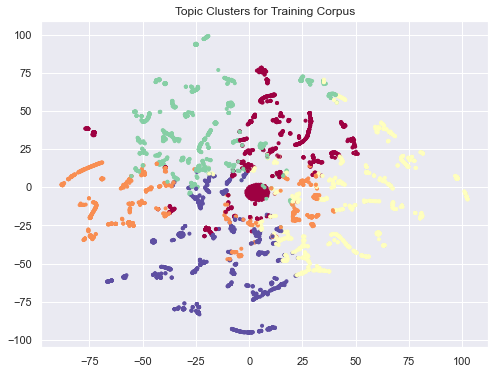

In [1112]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 42)
lda_tsne = tsne.fit_transform(dtm)
df_tsne = pd.DataFrame(lda_tsne)
plt.subplots(figsize = (8,6))
plt.scatter(df_tsne[0],df_tsne[1],c = df_dtm["Topic"],cmap = plt.cm.Spectral,s=9) 
ax = plt.title("Topic Clusters for Training Corpus")

In [1113]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda_best,vector1_food,countvectorizer_food,mds = "tsne")
p                          

PreparedData(topic_coordinates=            x        y  topics  cluster   Freq
topic                                         
2     150.222  -72.270       1        1 24.164
4      51.163 -159.968       2        1 20.771
3     -73.145   21.524       3        1 20.092
1     -66.410 -110.606       4        1 17.511
0      54.417   12.443       5        1 17.462, topic_info=         Term      Freq     Total Category  logprob  loglift
1453    staff   620.000   620.000  Default   30.000   30.000
542      food 1,254.000 1,254.000  Default   29.000   29.000
1357  service   581.000   581.000  Default   28.000   28.000
908      meal   380.000   380.000  Default   27.000   27.000
946      menu   243.000   243.000  Default   26.000   26.000
...       ...       ...       ...      ...      ...      ...
1734   whilst    27.719    28.472   Topic5   -5.053    1.718
1276    river    26.898    27.644   Topic5   -5.083    1.718
333      cook    27.025    27.785   Topic5   -5.079    1.717
428      dish    29.005    48.421   Topic5   -5.008    1.233
1048    order    33.745   217.512   Topic5   -4.856   -0.118

[203 rows x 6 columns], token_table=      Topic  Freq           Term
term                            
12        1 0.981      afternoon
13        2 0.968  afternoon tea
15        5 0.982            age
28        4 0.987         amount
33        2 0.966         anyone
...     ...   ...            ...
1734      5 0.983         whilst
1737      3 0.996           wife
1741      2 0.994           wine
1754      1 0.992           work
1761      3 0.990           year

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])